In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
from scipy.optimize import curve_fit
from scipy.signal import find_peaks, peak_widths, peak_prominences, medfilt
from scipy.ndimage import median_filter
import scipy as sp
import lightkurve as lk
import pylab as pl
from IPython import display
import pandas as pd
import copy
import os, shutil
from lightkurve import periodogram
from astropy import units
from itertools import repeat

from echelle import plot_echelle, interact_echelle

In [2]:
# star = 'TIC171591531'
star = 'TIC17372709'
# star = 'HD20203'
# star = 'V647Tau'
lk_search = lk.search_lightcurve(star, mission="TESS", cadence=120)
lk_search

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 41,2021,SPOC,120,17372709,0.0
1,TESS Sector 55,2022,SPOC,120,17372709,0.0


In [3]:
# lc = lk_search[1].download().remove_nans().remove_outliers()

lc_collection = lk.search_lightcurve(star, mission="TESS", cadence=120, author="SPOC").download_all()
lc = lc_collection[0].normalize() # defaults to pdcsap_flux now.
for l in lc_collection[1:]:
    lc = lc.append(l.normalize())
lc = lc.remove_nans().remove_outliers()

# Extract time and flux from the light curve
time, flux = lc.time.value, lc.flux.value

In [4]:
def amp_spectrum(t, y, fmin=None, fmax=None, nyq_mult=1., oversample_factor=5.):
    tmax = t.max()
    tmin = t.min()
    df = 1.0 / (tmax - tmin)
    
    if fmin is None:
        fmin = df
    if fmax is None:
        fmax = (0.5 / np.median(np.diff(t)))*nyq_mult

    freq = np.arange(fmin, fmax, df / oversample_factor)
    
    model = LombScargle(t, y)
    sc = model.power(freq, method="fast", normalization="psd")

    amp = np.sqrt(4./len(t)) * np.sqrt(sc)

    return freq, amp

def make_id_strings(ids):
    id_strings = []
    ids = ids.query("n_obs==n_obs") # remove rows without radial order assignments (modes without IDs)
    if "m_obs" not in ids.columns:
        ids["m_obs"] = np.zeros(len(ids)) # create m_obs, but set to zero, if this column doesn't exist
    for i,row in ids.iterrows():
        id_strings.append(str(int(row["n_obs"]))+str(int(row["l_obs"]))+str(int(row["m_obs"])))
    ids["nlm"] = id_strings
    return ids

def extra_echelle(f,a,ids,Dnu=6.83,obs_freqs=None,ax=None,plain=True,title=None,savefilename=None):
    """
    Plots the echelle diagram for a frequency and amplitude spectrum, including ell=2 and ell=3 modes.
    Inputs:
        f = frequency array
        a = amplitude array (same size as f, preferably smoothed)
        ids = Pandas df containing, e.g. frequencies and mode IDs.
        Dnu = 6.83 (not automatically determined)
        obs_freqs = None (for plotting observed frequencies with IDs when also plotting a full ts)
        plain = True (do not plot symbols if plain==True)
        title = None (supply a plot title)
        savefilename = None (supply a filename (incl. extension) to save plot)
    """

    norders = 15 # number of orders to plot

    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 8.5))
    ax2 = plot_echelle(f, a, Dnu, ax=ax, fmin=0, fmax=Dnu*(norders+1), mirror=True, scale='sqrt')
    ax.set_xlim(0, 1.2*Dnu)
    ax2.set_ylabel(r"Frequency (d$^{-1}$)")
    ax2.set_xlabel(r"Frequency mod $\Delta\nu$ (d$^{-1}$)")
    ax.set_ylim([0,Dnu*norders])
    plt.plot([Dnu, Dnu], [0, Dnu*norders], linestyle='dashed', color = 'blue')
    if title is not None:
        plt.title(f"{title}")

    if obs_freqs is not None:
        # obs radial modes
        add_echelle(obs_freqs.query("l_obs==0")["f_obs"],Dnu,'r','o','full',ax2,r'obs $\ell=0$')

        # obs dipole modes
        add_echelle(obs_freqs.query("l_obs==1")["f_obs"],Dnu,'r','^','full',ax2,r'obs $\ell=1$')
        
        # obs quadrupole modes
        add_echelle(obs_freqs.query("l_obs==2")["f_obs"],Dnu,'r','s','full',ax2,r'obs $\ell=2$')
        
        # obs octupole modes
#         add_echelle(obs_freqs.query("l_obs==3")["f_obs"],Dnu,'r','v','full',ax2,r'obs $\ell=3$')
        
        # obs no-id modes
        add_echelle(obs_freqs.query("l_obs==-1")["f_obs"],Dnu,'brown','x','full',ax2,r'unidentified')
        add_echelle(obs_freqs.query("m_obs==-9")["f_obs"],Dnu,'brown','+','full',ax2,r'unidentified')

    if plain==False:
        try:
            # obs radial modes
            add_echelle(ids.query("l_obs==0")["f_obs"],Dnu,'r','o','full',ax2,r'obs $\ell=0$')

            # obs dipole modes
            add_echelle(ids.query("l_obs==1")["f_obs"],Dnu,'r','^','full',ax2,r'obs $\ell=1$')
            
            # obs quadrupole modes
            add_echelle(ids.query("l_obs==2")["f_obs"],Dnu,'r','s','full',ax2,r'obs $\ell=2$')

            add_echelle(obs_freqs.query("m_obs==-9")["f_obs"],Dnu,'brown','+','full',ax2,r'unidentified')

            # obs octupole modes
#             add_echelle(ids.query("l_obs==3")["f_obs"],Dnu,'r','v','full',ax2,r'obs $\ell=3$')
        except:
            # print("could not find observed freqs")
            pass
        
        try:
            # model radial modes
            add_echelle(ids.query("l==0")["freq"],Dnu,'k','o','none',ax2,r'mdl $\ell=0$')
    
            # model dipole modes
            add_echelle(ids.query("l==1")["freq"],Dnu,'k','^','none',ax2,r'mdl $\ell=1$')

            # model quadrupole modes
            add_echelle(ids.query("l==2")["freq"],Dnu,'k','s','none',ax2,r'mdl $\ell=2$')
    
            # model octupole modes
            add_echelle(ids.query("l==3")["freq"],Dnu,'k','v','none',ax2,r'mdl $\ell=3$')
        except:
            # print("could not find model freqs")
            pass

    ax2.text(Dnu, Dnu*0.8, r"$\Delta\nu={:.2f}\thinspace$ ".format(Dnu), horizontalalignment='right', color='blue')

    try:
        ax.legend(fontsize='x-small')
    except:
        pass
    
    if savefilename is not None:
        plt.savefig(f"stars/{savefilename}",bbox_inches='tight')


def add_echelle(freq,Dnu,col,sym,fill,ax2,lbl=None):
    freq_x = np.mod(freq, Dnu) 
    freq_y = freq - np.mod(freq, Dnu) + Dnu/2.
    ax2.plot(freq_x, freq_y, c=col, marker=sym, linestyle='none', fillstyle=fill,label=lbl)
    ax2.plot(freq_x+Dnu, freq_y-Dnu, c=col, marker=sym, linestyle='none', fillstyle=fill)



In [111]:
# Sinusoidal function to fit the peaks
def sinusoidal_model(t, A, omega, phi, C):
    return A * np.sin(omega * t + phi) + C

def is_harmonic(f1, f2, tolerance):
    ratio = f2 / f1
    closest_integer = round(ratio)
    is_harmonic = abs(ratio - closest_integer) < tolerance

    # Check for sub-harmonics
    sub_ratio = f1 / f2  # inverse of the original ratio
    closest_sub_integer = round(sub_ratio)
    is_sub_harmonic = abs(sub_ratio - closest_sub_integer) < tolerance
    return is_harmonic or is_sub_harmonic

def prewhitener(time, flux, max_iterations=100, snr_threshold=5, nearby_peaks_tolerance=0.1,
                remove_harmonics=True, harmonic_tolerance=0.001,  
                fmin=5, fmax=72, nyq_mult=1, oversample_factor=5, name='star'):
    if not os.path.exists(f'pw/{name}'):
        os.makedirs(f'pw/{name}')
    else:
        shutil.rmtree(f'pw/{name}')
        os.makedirs(f'pw/{name}')

    ## Normalize the flux
    flux = flux/np.median(flux)
    flux_i = copy.deepcopy(flux)

    peak_freqs = []
    peak_amps = []
    peaks = []

    ## Initial amplitude spectrum
    freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
    amps_i *= 1000 # convert to ppt
    for n in range(max_iterations):
        ## Find all peaks
        peaks_i = find_peaks(amps_i)[0]
        
        ## If no peaks are found, break the loop
        if len(peaks_i) == 0:
            print('No more peaks found')
            break

        ## Fit and remove the highest peak
        amp = np.max(amps_i)
        freq = freqs_i[np.argmax(amps_i)]
        omega = 2 * np.pi * freq
        p0 = [amp, omega, 0.5, 0.5]
        params, pcov = curve_fit(sinusoidal_model, time, flux_i, p0=p0)
        ## Negative amp corrections. Flip sign, add pi to phase
        if params[0] < 0:
            params[0] *= -1.
            params[2] += np.pi
        
        peak_freqs.append(params[1]/(2*np.pi))
        # peak_amps.append(params[0]*1000)
        peak_amps.append(amp)
        flux_i -= sinusoidal_model(time, *params)

        ### New amplitude spectrum ###
        freqs_i, amps_i = amp_spectrum(t=time, y=flux_i, fmin=fmin, fmax=fmax, nyq_mult=nyq_mult, oversample_factor=oversample_factor)
        amps_i *= 1000 # convert to ppt

        ## Get SNR using a median filter, and check if it is above the threshold
        ## median filter size should be a bit larger than the expected FWHM of the peaks
        noise = median_filter(amps_i, size=int(len(amps_i)*(freqs_i[1]-freqs_i[0])/(freqs_i[-1]-freqs_i[0])))
        snr = np.max(amps_i) / np.median(noise)
        display.clear_output(wait=True)
        print(f'SNR: {snr}')
        print(f'SNR threshold: {snr_threshold}')
        if snr < snr_threshold:
            print('SNR threshold reached')
            break

    freq_amp = pd.DataFrame({'freq': peak_freqs, 'amp': peak_amps})

    ## Sorting the peaks by amplitude
    freq_amp = freq_amp.sort_values(by='freq', ascending=False)
    if remove_harmonics:
        # # # Harmonic ratio checking
        harmonics_idx = []
        for i in range(len(freq_amp)):
            for j in range(i+1, len(freq_amp)):
                if is_harmonic(freq_amp.iloc[i]['freq'], freq_amp.iloc[j]['freq'], tolerance=harmonic_tolerance):
                    harmonics_idx.append(j)
        freq_amp = freq_amp.drop(index=harmonics_idx)

    ## Remove overlapping or very nearby peaks, keep the highest amplitude one
    freq_amp = freq_amp.sort_values(by=['freq', 'amp'], ascending=False)

    freq_amp = freq_amp.reset_index(drop=True)
    to_drop = []
    for i in range(len(freq_amp)-1):
        if freq_amp.iloc[i]['freq'] - freq_amp.iloc[i+1]['freq'] < nearby_peaks_tolerance:
            if freq_amp.iloc[i]['amp'] < freq_amp.iloc[i+1]['amp']:
                to_drop.append(i)
            else:
                to_drop.append(i+1)
    freq_amp = freq_amp.drop(index=to_drop)

    
    # Save the frequencies and amplitudes
    # freq_amp.to_csv(f'pw/{star}_frequencies.csv', index=False)
    print('Done!')
    return freq_amp.freq.values, freq_amp.amp.values
    # return peak_freqs, peak_amps

In [112]:
peak_freqs1, peak_amps1 = prewhitener(time, flux, snr_threshold=5, remove_harmonics=True)
peak_freqs2, peak_amps2 = prewhitener(time, flux, snr_threshold=5, remove_harmonics=False)

SNR: 4.960661060311977
SNR threshold: 5
SNR threshold reached
Done!


/Users/anujgautam/.pyenv/versions/3.11.4/lib/python3.11/site-packages/astropy/timeseries/periodograms/lombscargle/implementations/fast_impl.py:102: RuntimeWarning: invalid value encountered in divide
  tan_2omega_tau = (S2 - 2 * S * C) / (C2 - (C * C - S * S))
/var/folders/sb/dk38f76562ng2fhw85ll93vc0000gp/T/ipykernel_51155/898117763.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot(2, 1, 1)


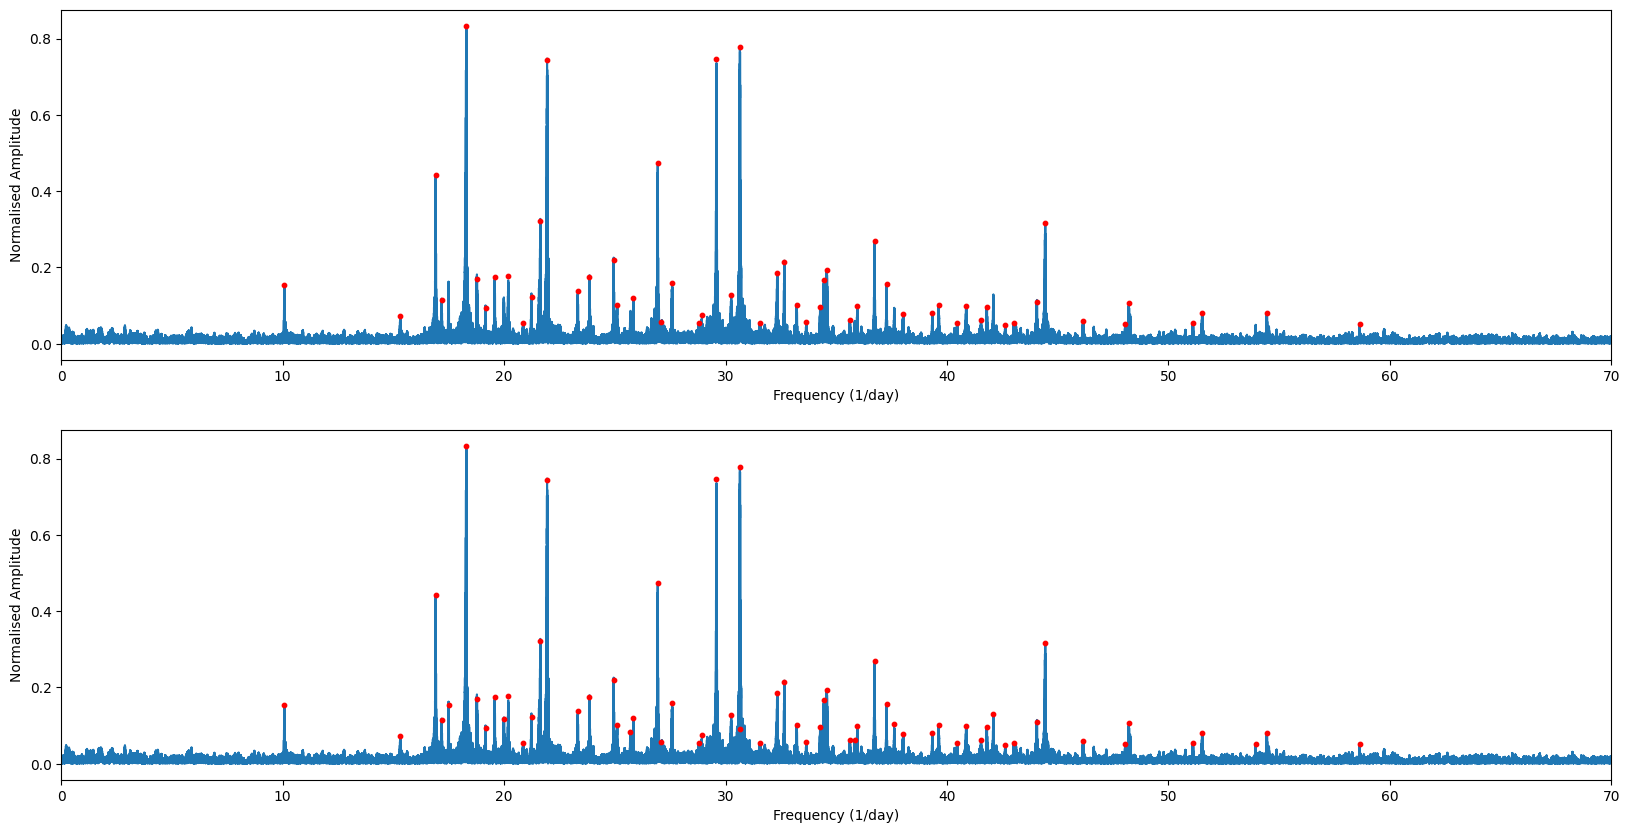

In [113]:
# Plot the final periodogram after pre-whitening
freqs, amps = amp_spectrum(t=time, y=flux/np.median(flux), fmin=0, fmax=90, nyq_mult=1, oversample_factor=5)
plt.figure(figsize=(20, 10))
plt.title("Lomb-Scargle Periodogram with peaks")

ax1 = plt.subplot(2, 1, 1)
ax1.plot(freqs, amps*1000, zorder=1)
ax1.scatter(peak_freqs1, peak_amps1, s=10, color='red', zorder=2)
ax1.set_xlabel("Frequency (1/day)")
ax1.set_ylabel("Normalised Amplitude")
ax1.set_xlim(0, 70)
# ax1.set_xlim(15, 30)
# ax1.set_xlim(30, 40)

ax2 = plt.subplot(2, 1, 2)
ax2.plot(freqs, amps*1000, zorder=1)
ax2.scatter(peak_freqs2, peak_amps2, s=10, color='red', zorder=2)
ax2.set_xlabel("Frequency (1/day)")
ax2.set_ylabel("Normalised Amplitude")
ax2.set_xlim(ax1.get_xlim())
ax2.set_ylim(ax1.get_ylim())

plt.show()

In [109]:
len(peak_freqs1), len(peak_amps1)

(56, 56)

In [355]:
### Load star IDs
dtypes = {'ID': 'str', 'f_obs': 'float', 'a_obs': 'float', 'n_obs': 'int', 'l_obs': 'int', 'm_obs': 'int'}
# ids = pd.read_csv(f"stars/HD23642_revised_ids_all3.csv", delim_whitespace=True, dtype=dtypes)
ids2 = pd.DataFrame()
ids2["ID"] = np.arange(1, len(peak_freqs)+1)
ids2["f_obs"], ids2["a_obs"], ids2['n_obs'], ids2['l_obs'], ids2['m_obs'] = peak_freqs, peak_amps, 6, -1, -9
ids2 = make_id_strings(ids2)
# ids


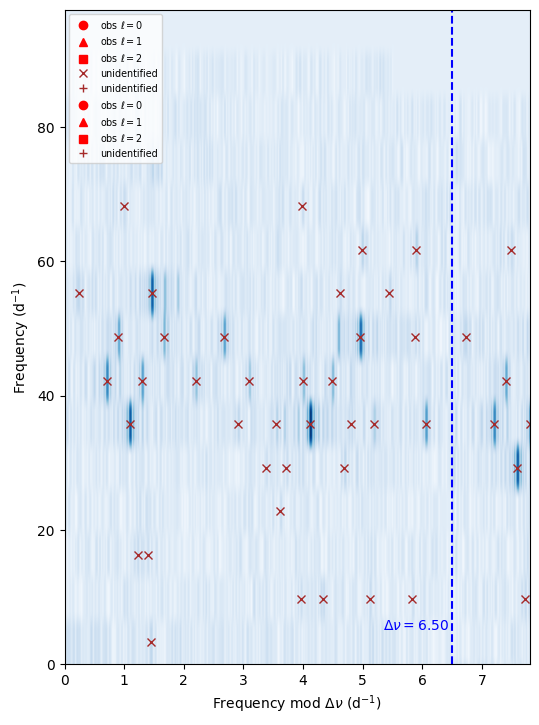

In [374]:
Dnu = 6.5
# extra_echelle(freqs, amps, ids, obs_freqs=ids, Dnu=Dnu, plain=False)
extra_echelle(freqs, amps, ids2, obs_freqs=ids, Dnu=Dnu, plain=False)

In [334]:
# Fold the light curve at the frequency of the highest peak for visualization
highest_peak_frequency = peak_freqs[0]
folded_time = time % (1 / highest_peak_frequency)

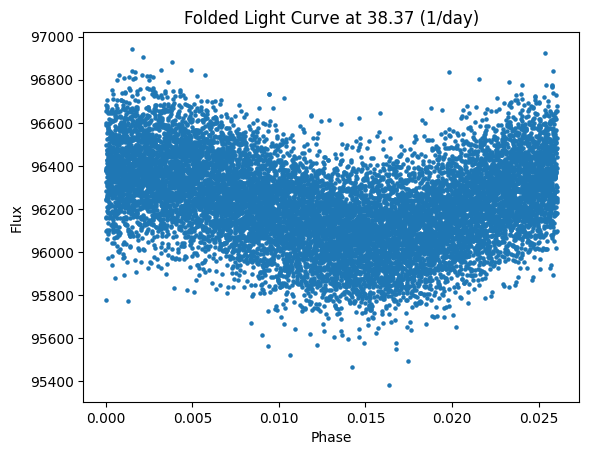

In [282]:
# Plot folded light curve
plt.figure()
plt.scatter(folded_time, flux, s=5)
plt.title(f"Folded Light Curve at {highest_peak_frequency:.2f} (1/day)")
plt.xlabel("Phase")
plt.ylabel("Flux")
plt.show()

In [6]:
x = [1,2,3,4,5]

In [7]:
x.pop(0)

1